## Heart Disease Prediction Using a Deep Learning Model
 
by: Al Sabay, SMU MS Datascience Graduate Research Studies

This Deep Learning model to predict Heart Disease uses the Keras API. The Neural Net architecture of this model is a Perceptron type and uses the "categorical_crossentropy" objective function, the Adam optimizer, L2 and Dropout layers for regularization and has 3 hidden layers. Hyperparameters, regularization, number of layers, number of neuron units and the number of epochs was carefully chosen to achieve accuracy metrics in the range of 95-97%. These results are shown in the evaluation plots shown below. Each run achieves very minor variations and the model exhibits excellent stability.

The dataset used is what is considered to be the "Gold Standard" in Heart Disease Prediction studies from the UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/). The "cleveland.data" file from the repository was processed through a synthesis process in order to anonymize the data (no original data appears in the data set used in this model) and processed using the synthpop library to increase the data volume in order to be suitable for Neural Network Model processing. The synthesized surrogate dataset of shape 60K x 39 has the same data characteristics as the original cleveland dataset (see https://github.com/alsabay/SynthHD on how this was done).

### Initialization

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import itertools
import pandas as pd
import keras_metrics
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import metrics
from sklearn.metrics import confusion_matrix
from keras import regularizers 
from sklearn.metrics import roc_curve, auc, precision_score, accuracy_score, recall_score

import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = "Times New Roman"

np.random.seed(306)  # for reproducibility

# network and training
NB_EPOCH = 90
BATCH_SIZE = 1024
VERBOSE = 0
NB_CLASSES = 2   # Heart Disease diagnosis yes = 1, no = 0
OPTIMIZER = Adam() # optimizer
N_HIDDEN = 128
TRAINING_SPLIT = 0.6 # how much from all of the data is split for training
VALIDATION_SPLIT=0.4 # how much in TRAIN is reserved for VALIDATION
DROPOUT = 0.5



Using TensorFlow backend.


### Data Preparation

In [2]:
# read synthetic cleveland dataset from full cleveland.data
df_main = pd.read_table("data/syn_cleveland.csv", sep=',')

# Neural Net transfer function likes to work with floats
df_main.astype(float)

# Normalize values to range [0:1]
df_main /= df_main.max()

# split data into independent and dependent variables
y_all = df_main['num']
X_all = df_main.drop(columns = 'num')

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size = TRAINING_SPLIT, test_size = 1 - TRAINING_SPLIT)
Y_train = np_utils.to_categorical( y_train, NB_CLASSES) 
Y_test = np_utils.to_categorical( y_test, NB_CLASSES)

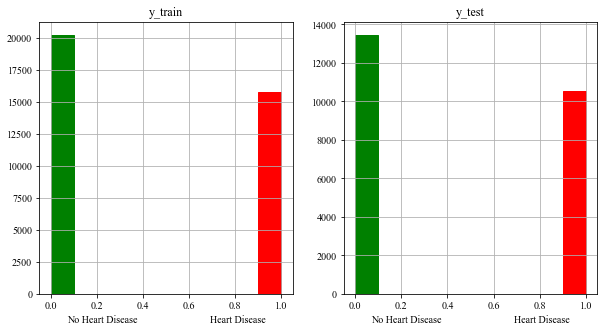

In [3]:
# check class distributions for label balance
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,5))

# plot histograms
axs[0].set_xlabel('No Heart Disease                             Heart Disease')
axs[0].set_title('y_train')
axs[0].grid()
axs[0].hist(y_train)
axs[0].get_children()[0].set_color('g')
axs[0].get_children()[9].set_color('r')
axs[1].set_title('y_test')
axs[1].set_xlabel('No Heart Disease                             Heart Disease')
axs[1].grid()
axs[1].hist(y_test)
axs[1].get_children()[0].set_color('g')
axs[1].get_children()[9].set_color('r')
plt.show()

In [4]:
# check that all inputs are normalized to range [0:1]
X_all.describe().T

,count,mean,std,min,25%,50%,75%,max
age,60000.0,0.705943,0.117166,0.376623,0.610390,0.714286,0.792208,1.0
sex,60000.0,0.677217,0.467545,0.000000,0.000000,1.000000,1.000000,1.0
cp,60000.0,0.791971,0.237629,0.250000,0.750000,0.750000,1.000000,1.0
trestbps,60000.0,0.658369,0.087869,0.470000,0.600000,0.650000,0.700000,1.0
htn,60000.0,0.619883,0.485419,0.000000,0.000000,1.000000,1.000000,1.0
chol,60000.0,0.440395,0.090281,0.223404,0.375887,0.432624,0.489362,1.0
cigs,60000.0,0.171115,0.197728,0.000000,0.000000,0.101010,0.303030,1.0
years,60000.0,0.284111,0.284203,0.000000,0.000000,0.277778,0.555556,1.0
fbs,60000.0,0.153167,0.360151,0.000000,0.000000,0.000000,0.000000,1.0
famhist,60000.0,0.623950,0.484397,0.000000,0.000000,1.000000,1.000000,1.0


### Neural Net Setup, Train and Validation

In [5]:
# set up the NN model, Dropout & L2 regularization 
model = Sequential()
model.add(Dense(N_HIDDEN, input_shape=(37,), kernel_regularizer = regularizers.l2( 0.01)))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4864      
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [6]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

In [7]:
print(model.metrics_names) # metrics to retrieve from score after evaluation

['loss', 'acc', 'precision', 'recall']


In [8]:
model.metrics_names


['loss', 'acc', 'precision', 'recall']


Final test scores:

Test Loss: 0.11508465440571308
Test Accuracy: 0.9672083333333333
Test Precision: 0.9672083333333333
Test Recall: 0.9672083333333333


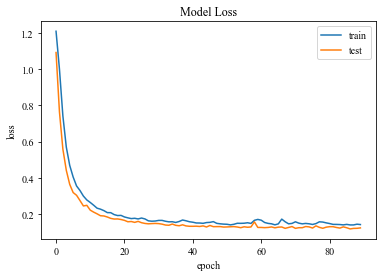

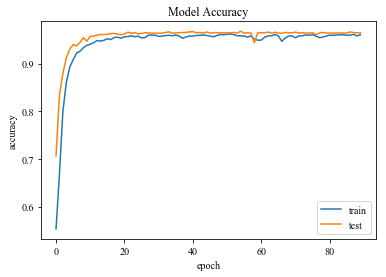

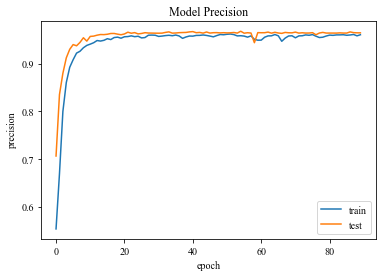

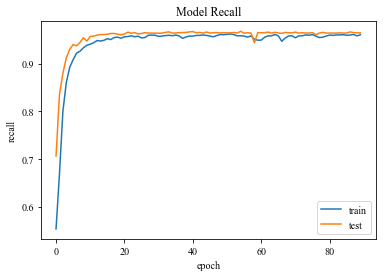

Confusion matrix, without normalization
[[13452     3]
 [  784  9761]]
Normalized confusion matrix
[[1.00e+00 2.23e-04]
 [7.43e-02 9.26e-01]]


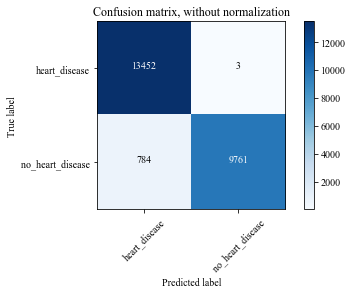

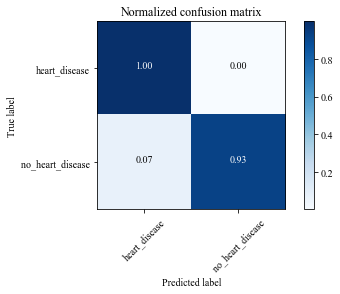

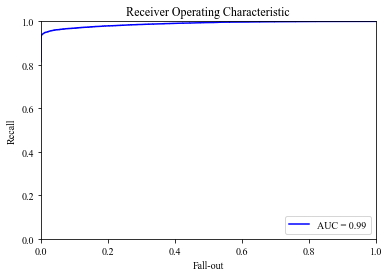

Text(0,0.5,'Score')

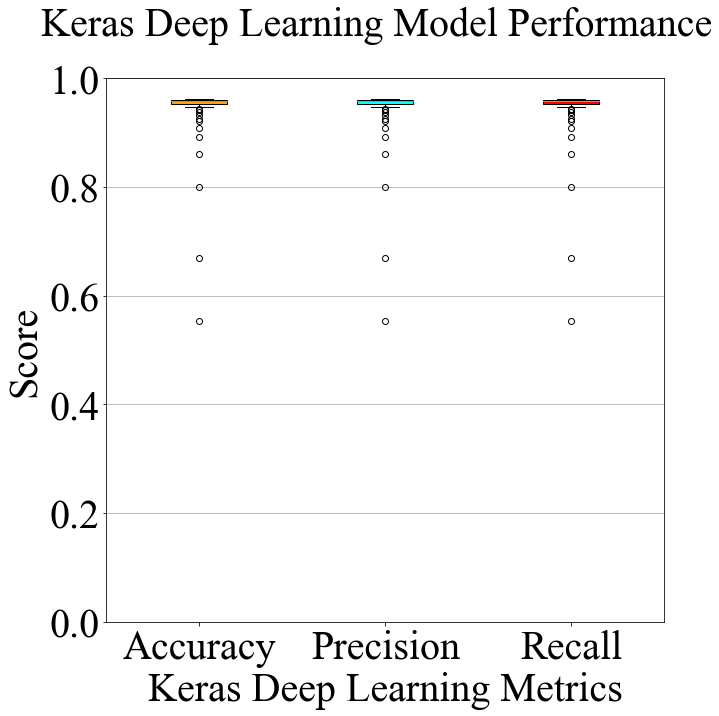

In [9]:
# train the model
history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# make prediction for ROC
y_pred = model.predict_classes(X_test)

score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print('\nFinal test scores:')
print('\nTest Loss:', score[0])
print('Test Accuracy:', score[1])
print('Test Precision:', score[2])
print('Test Recall:', score[3])

# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = ['heart_disease', 'no_heart_disease']
cnf_matrix = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# plot ROC Curve
predictions = model.predict_proba(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test,predictions[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
#plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()


# plot boxplot accuracy, precision, recall
bplot = [history.history['acc'], history.history['precision'], history.history['recall']]
labels = ['Accuracy', 'Precision', 'Recall']

colors = ['orange', 'cyan', 'red']

fig = plt.figure(figsize=(10,10))
fig.suptitle('Keras Deep Learning Model Performance', fontsize=40)

a = fig.add_subplot(111)
a.tick_params(axis = 'both', which = 'major', labelsize = 40)
a.set_ylim(0,1)
bplot = a.boxplot(bplot, labels=labels,
                  vert=True, patch_artist=True)

# color the boxes
for bp in bplot:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
a.yaxis.grid(True)
a.set_xlabel('Keras Deep Learning Metrics',fontsize=40)
a.set_ylabel('Score',fontsize=40)

In [10]:
acc=np.mean(y_test==y_pred)
print( acc)

0.9672083333333333


In [11]:
# save the model for later use
model.save('models/heart_disease_predict_A.h5')